In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [31]:
tf.config.list_physical_devices('GPU')

[]

In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5705671537204055263
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3113452494550607987
physical_device_desc: "device: XLA_CPU device"
]


In [30]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt.xml')

In [57]:
img_arr = cv2.imread('./images/2020-08-27-200311.jpg')
# img_arr = cv2.resize(img_arr, (48,48))
# img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
# faces = face_cascade.detectMultiScale(img_arr)     #gives bounding box coordinates

In [58]:
img_arr.shape

(480, 640, 3)

In [59]:
faces = face_cascade.detectMultiScale(img_arr)     #gives bounding box coordinates

In [60]:
faces[0][1],faces[0][3]

(108, 267)

In [61]:
crop_img = img_arr[108:108+267, 204:204+267]
crop_img.shape

(267, 267, 3)

In [62]:
import matplotlib.pyplot as plt

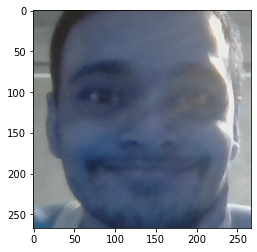

In [63]:
imgplot = plt.imshow(crop_img)

In [44]:
cv2.imshow("cropped", crop_img)
cv2.waitKey(0)

error: OpenCV(4.4.0) /tmp/pip-req-build-5eq00dzn/opencv/modules/highgui/src/window.cpp:651: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [46]:
img = cv2.resize(crop_img, (48,48))
img.shape

(48, 48)

In [2]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow import keras
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array

In [4]:
glob('./images/train/*')

['./images/train/happy',
 './images/train/surprise',
 './images/train/neutral',
 './images/train/sad']

In [5]:
for x in glob('./images/train/*'):
    print(x.split('/')[-1], len(glob(x+'/*')))

happy 7164
surprise 3205
neutral 4982
sad 4938


In [6]:
TRAIN_PATH = './images/train/'
VALID_PATH = './images/validation/'
MODEL_SAVE_PATH = './models/model_weights.h5'
BATCH_SIZE = 32
NUM_CLASSES = 4

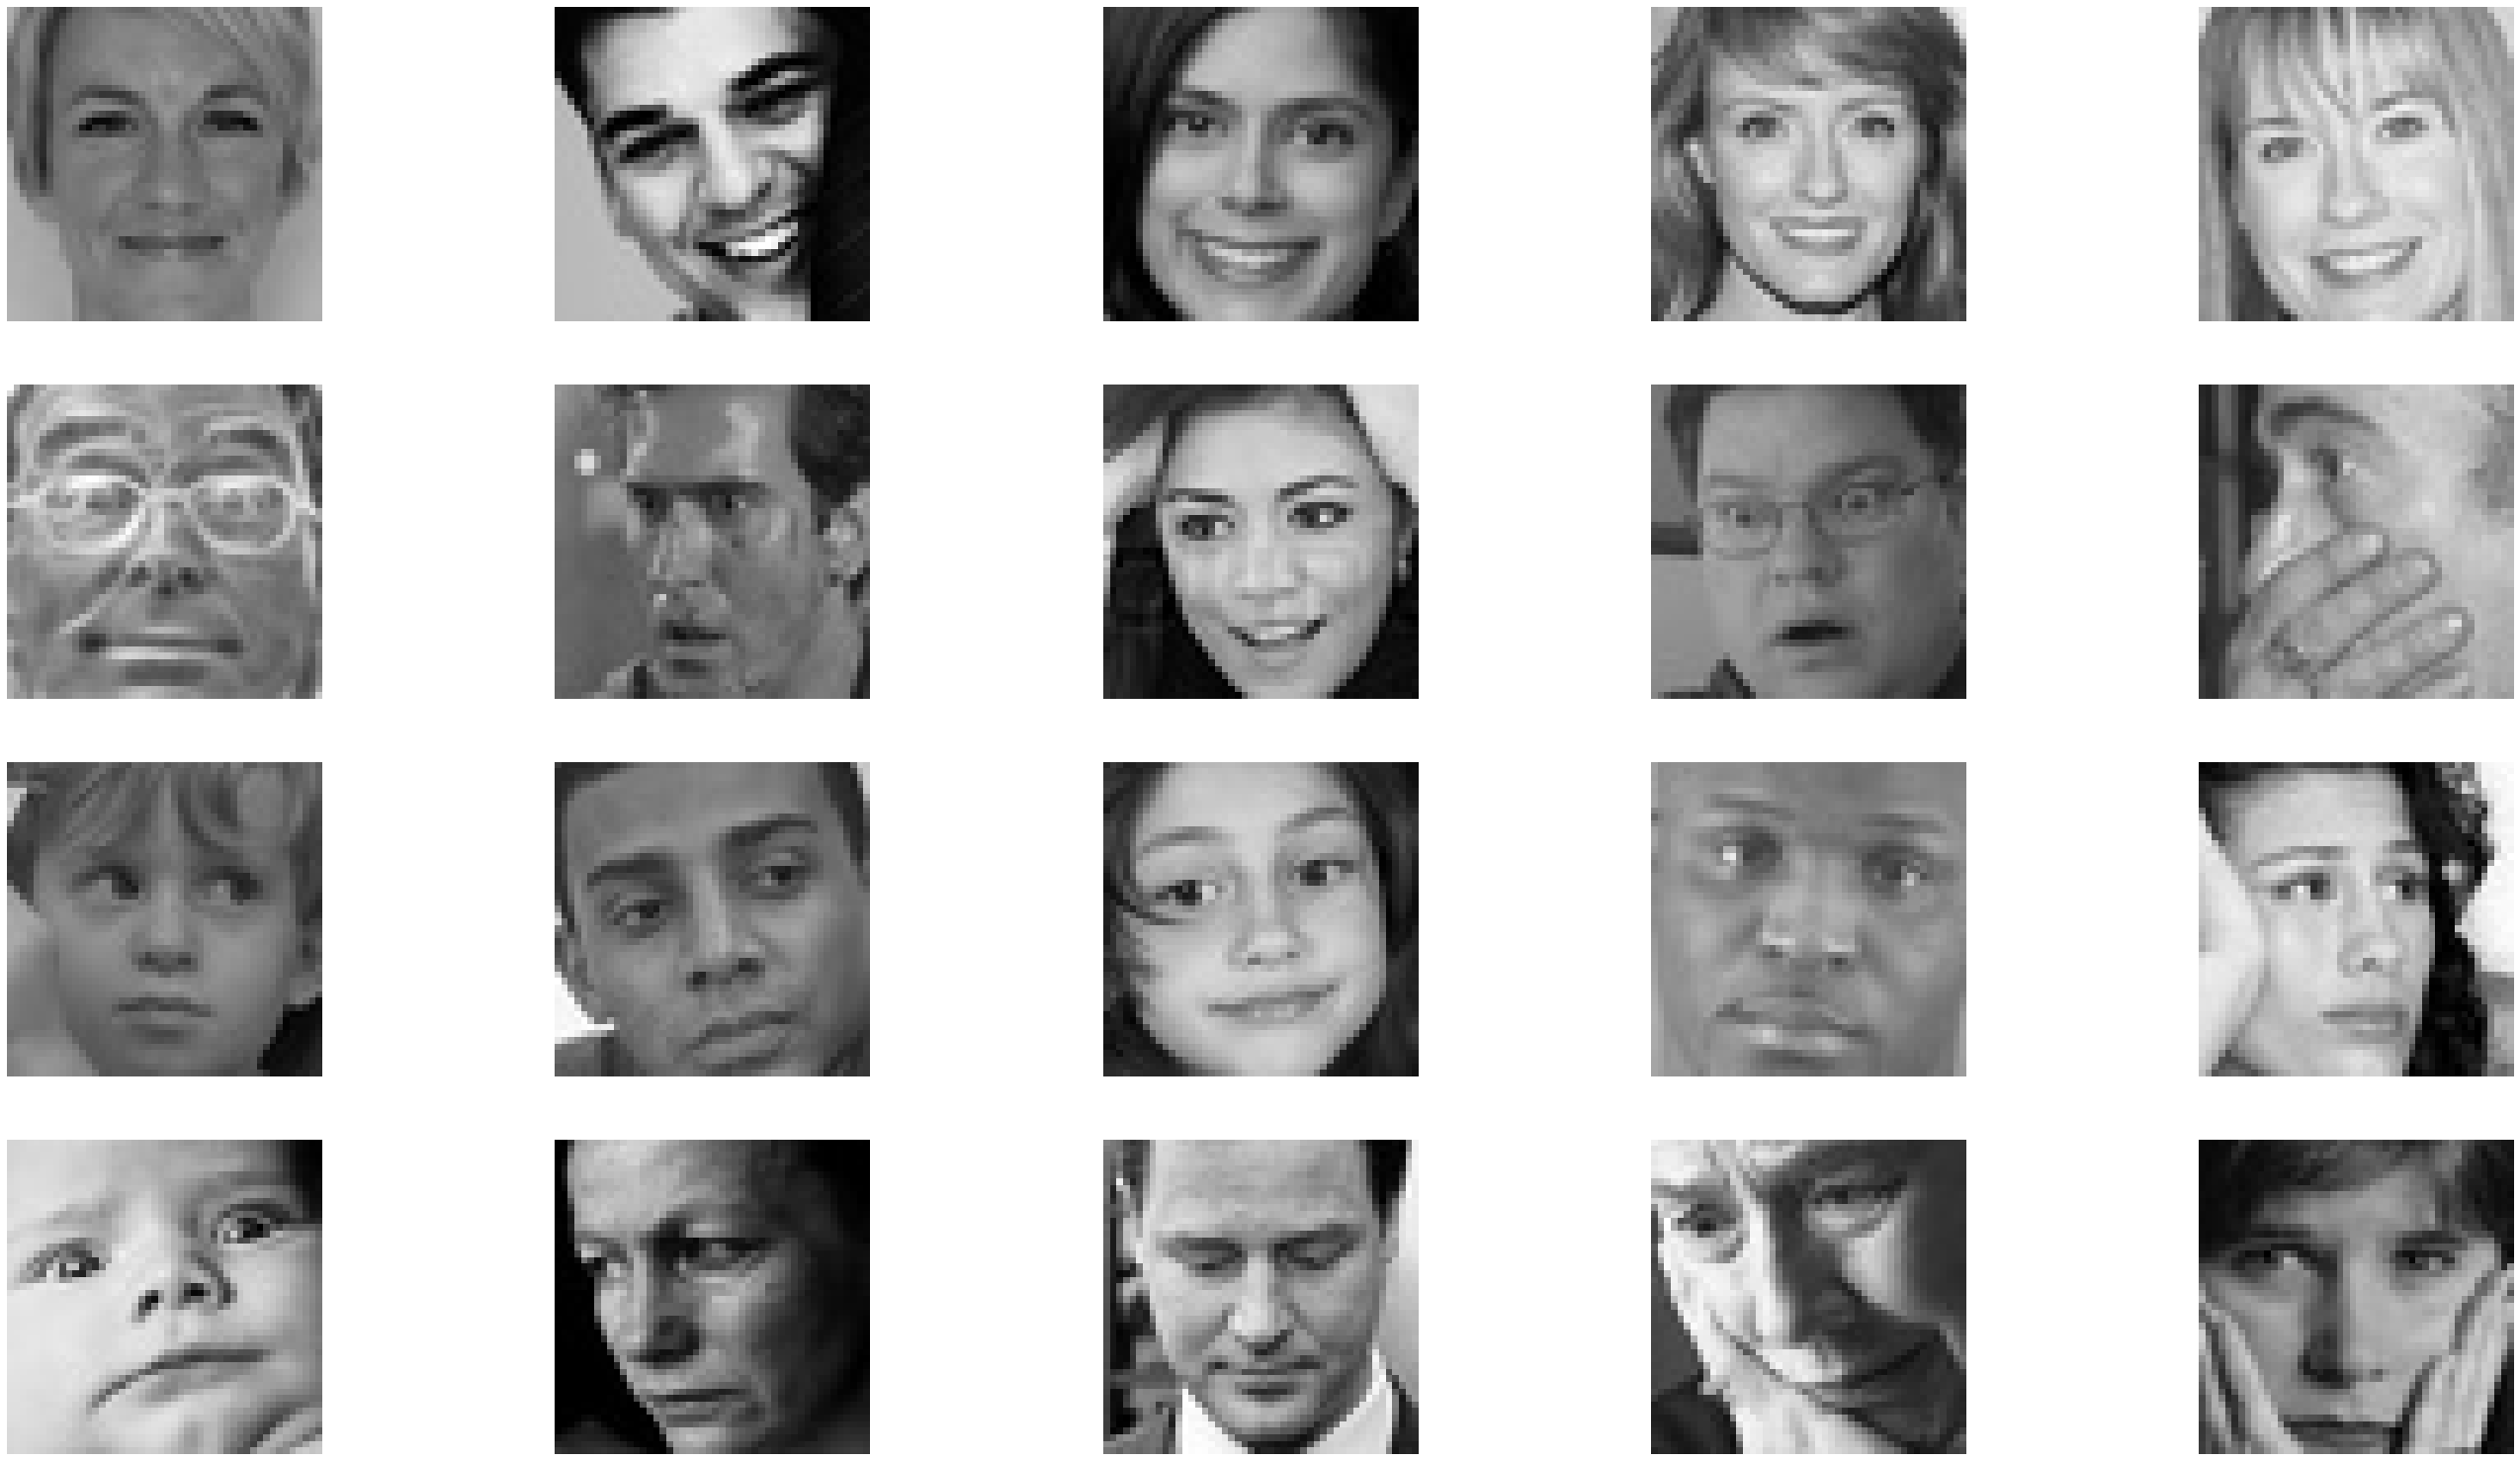

In [7]:
plt.figure(0, figsize=(48,48))
cpt = 0

for expression in os.listdir(TRAIN_PATH):
    for i in range(1,6):
        cpt = cpt + 1
        sp=plt.subplot(7,5,cpt)
        sp.axis('Off')
        img_path = TRAIN_PATH + expression + "/" +os.listdir(TRAIN_PATH + expression)[i]
        img = load_img( img_path, target_size=(48,48))
        plt.imshow(img)


plt.show()

In [8]:
from keras import regularizers

In [9]:
# model from scratch - self made

datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  horizontal_flip=True)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(TRAIN_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True,
                                                   color_mode = 'grayscale',
                                                   class_mode = 'categorical')

valid_generator = datagen_valid.flow_from_directory(VALID_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False,
                                                   color_mode = 'grayscale',
                                                   class_mode = 'categorical')

print(train_generator.classes)

Found 20289 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
[0 0 0 ... 3 3 3]


In [10]:
valid_generator.class_indices

{'happy': 0, 'neutral': 1, 'sad': 2, 'surprise': 3}

In [11]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam

In [12]:
def conv_layer(model, num_filters, kernel_size, pad='same'):
    model.add(Conv2D(num_filters, kernel_size, padding=pad))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    return model 

def fc_layer(model, num_filters):
    model.add(Dense(num_filters, bias_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))  
    return model

model = Sequential()
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model = conv_layer(model, 128, (3,3))
model = conv_layer(model, 256, (5,5))
model = conv_layer(model, 256, (3,3))
# model = conv_layer(model, 512, (3,3))
# model = conv_layer(model, 512, (3,3))

model.add(Flatten())

model = fc_layer(model, 1024)
# model = fc_layer(model, 512)
model = fc_layer(model, 256)

model.add(Dense(NUM_CLASSES, activation= 'softmax'))

model.compile(optimizer= Adam() , loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

In [18]:
model = load_model('./models/model_weights_28_1.h5')

In [19]:
MODEL_SAVE_PATH = './models/model_weights_28_2.h5'

# model = load_model('./models/model_weights_scratch_local_1.h5')

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=50,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

Epoch 1/50
634/634 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8658
Epoch 00001: val_accuracy improved from -inf to 0.77016, saving model to ./models/model_weights_28_2.h5
634/634 [==============================] - 19s 30ms/step - loss: 0.3427 - accuracy: 0.8658 - val_loss: 0.7233 - val_accuracy: 0.7702
Epoch 2/50
634/634 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8650
Epoch 00002: val_accuracy improved from 0.77016 to 0.79355, saving model to ./models/model_weights_28_2.h5
634/634 [==============================] - 21s 34ms/step - loss: 0.3463 - accuracy: 0.8650 - val_loss: 0.6402 - val_accuracy: 0.7935
Epoch 3/50
634/634 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8647
Epoch 00003: val_accuracy did not improve from 0.79355
634/634 [==============================] - 19s 30ms/step - loss: 0.3432 - accuracy: 0.8647 - val_loss: 0.8367 - val_accuracy: 0.7351
Epoch 4/50
633/634 [===========================

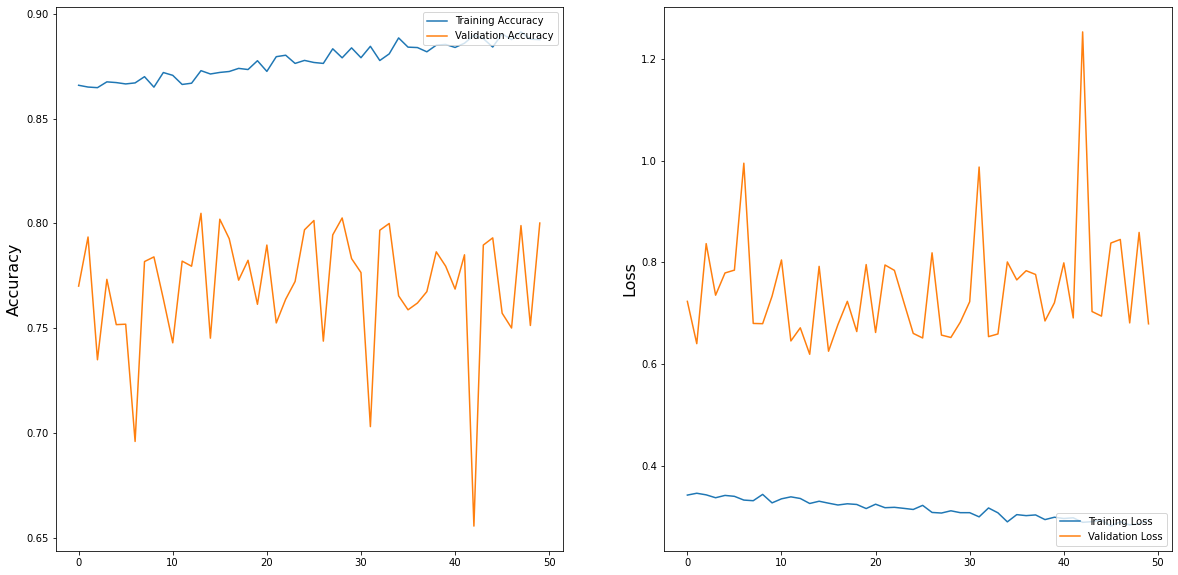

In [20]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower right')

plt.show()

In [ ]:
80202

In [12]:
# prediction on batch

predictions = model.predict_generator(generator=valid_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()
class_names

In [1]:
img = load_img('./images/2020-08-27-200311.jpg' , target_size=(48,48), grayscale=True)
img = img_to_array(img)
image = np.expand_dims(img, axis=0)
print(image.shape)
plt.imshow(img)

In [53]:
img.shape

(48, 48, 1)

In [14]:
from skimage import transform

In [15]:
img_arr = np.array(img)
img_arr.shape

(48, 48)

In [55]:
# image = np.array(img)
# image = np.expand_dims(image, axis=0)
# image = transform.resize(image, (48, 48, 1))
image = np.expand_dims(img, axis=0)
image.shape

(1, 48, 48, 1)

In [71]:
model.predict(image)[0]

array([1.000000e+00, 0.000000e+00, 2.845688e-34, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00], dtype=float32)

In [37]:
result = {}
for emotion, probability in zip(list(valid_generator.class_indices.keys()), model.predict(image)[0]):
    result[emotion] = round(probability*100,2)
#     print(emotion, round(probability*100, 2))
result

{'angry': 6.52,
 'disgust': 0.02,
 'fear': 13.58,
 'happy': 1.83,
 'neutral': 19.07,
 'sad': 57.49,
 'surprise': 1.48}

In [51]:
model.predict_classes(image)[0]

0

In [18]:
valid_generator.class_indices.keys()

dict_keys(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [41]:
# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
from gevent.pywsgi import WSGIServer

In [49]:
# Define a flask app
app = Flask(__name__)

In [43]:
model._make_predict_function()          # Necessary
# print('Model loaded. Start serving...')
print('Model loaded. Check http://127.0.0.1:5000/')

AttributeError: 'Sequential' object has no attribute '_make_predict_function'

In [67]:
def model_predict(img_path, model):
    img = load_img(img_path, target_size=(48, 48), grayscale=True)

    # Preprocessing the image
    x = img_to_array(img)
    # x = np.true_divide(x, 255)
    x = np.expand_dims(x, axis=0)

    # Be careful how your trained model deals with the input
    # otherwise, it won't make correct prediction!
#     x = preprocess_input(x, mode='caffe')

    preds = model.predict(x)[0]
    return preds


# @app.route('/', methods=['GET'])
# def index():
#     # Main page
#     return render_template('index.html')

In [68]:
model_predict('./images/2020-02-26-193723.jpg', model)

1.0

In [1]:
import numpy as np
import cv2
from tensorflow import keras
from keras.models import load_model

model = load_model('./models/model_weights_scratch_local_1.h5')


In [18]:
img_arr = cv2.imread('./images/train/sad/10008.jpg')
img_arr = cv2.resize(img_arr, (48,48))
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
img_arr = img_arr.reshape(1, 48, 48, 1)
preds = model.predict(img_arr)[0]
results = np.array([round(x*100, 2) for x in list(preds)])
results

array([  0.,   0.,   0., 100.,   0.,   0.,   0.])

In [19]:
results[0]

0.0

In [20]:
model.predict_classes(img_arr)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([3])

In [50]:
from flask import Flask, redirect, url_for, request
from flask import render_template

app = Flask(__name__)

In [51]:
@app.route('/operation', methods = ['POST', 'GET'])
def operation():
    if request.method == 'POST':
        a = request.form['a']
        b = request.form['b']

        if a == "" and b == "":
            return redirect(url_for('empty_value'))
       
        add_val = int(a) + int(b)
        print("addition: ", add_val)

        mul_val = int(a) * int(b)
        print("multiplication: ", mul_val)

        return f"addition is: {add_val}   multiplication is :{mul_val}"

In [7]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  horizontal_flip=True,
                                  zoom_range=0.2)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(TRAIN_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical')

valid_generator = datagen_valid.flow_from_directory(VALID_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical')

print(train_generator.classes)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
[0 0 0 ... 6 6 6]


In [8]:
train_generator.class_indices, valid_generator.class_indices

({'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6},
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [9]:
from keras.applications.resnet50 import ResNet50

from keras.layers import Flatten, Dense, Dropout, BatchNormalization, MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [10]:
model_res = ResNet50(include_top=False, weights=None, input_shape=(48,48,3))

/home/nilesh/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [11]:
x = Flatten()(model_res.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)

predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)

final_model = Model(input= model_res.input, output = predictions)

final_model.compile(optimizer= Adam() , loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

/home/nilesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [14]:
MODEL_SAVE_PATH = './models/model_weights.h5'

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = final_model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=100,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])


Epoch 1/100
172/450 [==========>...................] - ETA: 2:49 - loss: 1.9389 - accuracy: 0.2167

KeyboardInterrupt: 

In [15]:
train_generator.n

28821

In [16]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# # load color (BGR) image
# img = cv2.imread(human_files[6000])
# plt.imshow(img)
# plt.show()
# # convert BGR image to grayscale
# print("Grayscale Image")
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray)
# plt.show()

# # find faces in image
# faces = face_cascade.detectMultiScale(gray)     #gives bounding box coordinates

# # print number of faces detected in the image
# print('Number of faces detected:', len(faces))

# # get bounding box for each detected face
# for (x,y,w,h) in faces:
#     # add bounding box to color image
#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# # convert BGR image to RGB for plotting
# cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# # display the image, along with bounding box
# plt.imshow(cv_rgb)
# plt.show()

In [18]:
dir(face_cascade)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'convert',
 'detectMultiScale',
 'detectMultiScale2',
 'detectMultiScale3',
 'empty',
 'getFeatureType',
 'getOriginalWindowSize',
 'isOldFormatCascade',
 'load',
 'read']